In [2]:
import pytesseract # uses https://github.com/UB-Mannheim/tesseract/wiki
import cv2
import matplotlib.pyplot as plt
import re
import os

In [3]:
!tesseract --version

tesseract v5.3.3.20231005
 leptonica-1.83.1
  libgif 5.2.1 : libjpeg 8d (libjpeg-turbo 2.1.4) : libpng 1.6.40 : libtiff 4.6.0 : zlib 1.2.13 : libwebp 1.3.2 : libopenjp2 2.5.0
 Found AVX512BW
 Found AVX512F
 Found AVX512VNNI
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.2 zlib/1.3 liblzma/5.4.4 bz2lib/1.0.8 liblz4/1.9.4 libzstd/1.5.5
 Found libcurl/8.3.0 Schannel zlib/1.3 brotli/1.1.0 zstd/1.5.5 libidn2/2.3.4 libpsl/0.21.2 (+libidn2/2.3.3) libssh2/1.11.0


In [4]:
print(pytesseract.get_tesseract_version())

5.3.3.20231005


## Get GPS


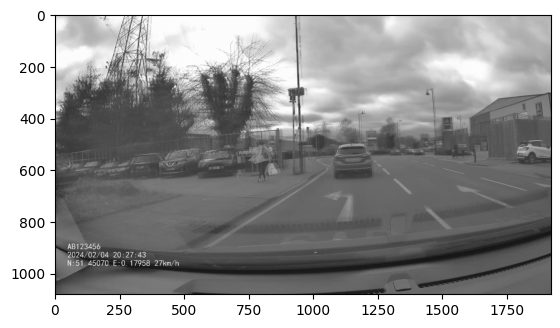

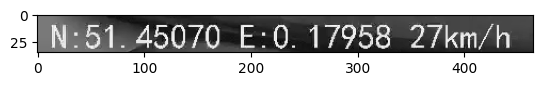

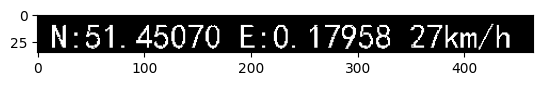

In [15]:
# Load the video
video_path = 'testVideo.ts'
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
if width == 1920 and height == 1080:
    window_ocr_dim = (slice(940, 975), slice(35, 500))
else:
    window_ocr_dim = (slice(2020, 2100), slice(50, 1000))

# Read the first frame
ret, frame = cap.read()
cv2.destroyAllWindows()
cap.release()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(frame, cmap='gray')
plt.show()

roi = frame[window_ocr_dim]
plt.imshow(roi, cmap='gray')
plt.show()

_, roi = cv2.threshold(roi, 200, 255, cv2.THRESH_BINARY)
plt.imshow(roi, cmap='gray')
plt.show()


In [16]:
text = pytesseract.image_to_string(roi)
print("Extracted Text:", text)

Extracted Text: N:51. 45070 E:0. 17958 27km/h


In [17]:
print("Extracted Text:", repr(text))

Extracted Text: 'N:51. 45070 E:0. 17958 27km/h\n'


In [10]:
lines = text.splitlines()
# Get the last line
last_line = lines[-1]
print(last_line)
# Use regular expression to extract numeric values (including decimals)
numeric_values = re.findall(r'\d+', last_line)
print(numeric_values)
# Join the numeric values into a string
N = ".".join(numeric_values[0:2])
print("N=",N)
E = ".".join(numeric_values[2:4])
print("E=",E)
speed = int(numeric_values[-1])
print("Speed=",speed)

N:51. 45070 E:0. 17958 27km/h
['51', '45070', '0', '17958', '27']
N= 51.45070
E= 0.17958


## Testing Code

In [11]:
def get_gps(frame, window_dim):
    failed = False
    gps_n = 0
    gps_e = 0
    speed = 0

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Turn frame greyscale
    window = frame[window_dim]  # Select window (in bottom left)
    _, window = cv2.threshold(window, 200, 255, cv2.THRESH_BINARY)  # Apply threshold for white pixels

    text = pytesseract.image_to_string(window)  # use Tesseract OCR to get text
    try:
        # Use string manipulation to get GPS and Speed from text
        last_line = text.splitlines()[-1]
        numeric_values = re.findall(r'\d+', last_line)

        gps_n = float(".".join(numeric_values[0:2]))
        gps_e = float(".".join(numeric_values[2:4]))
        speed = int(numeric_values[-1])
        if len(numeric_values) != 5:
            speed = 0
    except:
        failed = True
        print("failed")

    # return GPS N, GPS E, Speed
    return gps_n, gps_e, speed, failed

N:51.4507, E:0.17958, 27, False. count:0


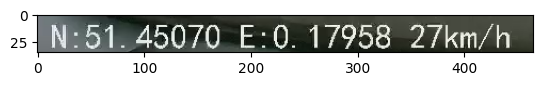

N:51.45064, E:0.17953, 30, False. count:25


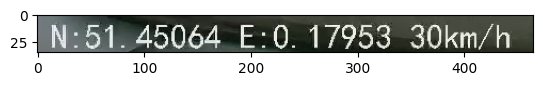

N:51.45056, E:0.17943, 31, False. count:50


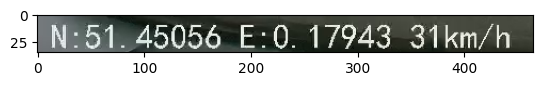

N:51.4505, E:0.17933, 32, False. count:75


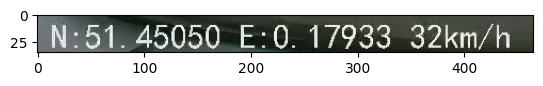

N:51.45045, E:0.17923, 31, False. count:100


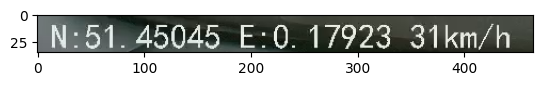

N:51.45039, E:0.17915, 31, False. count:125


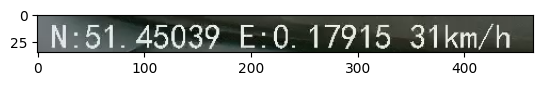

In [22]:
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_rate = round(cap.get(cv2.CAP_PROP_FPS))
# Check if the resolution is 1920x1080 (1080p)
if width == 1920 and height == 1080:
    window_ocr_dim = (slice(940, 975), slice(35, 500))
else:
    window_ocr_dim = (slice(2020, 2100), slice(50, 1000))
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if frame_count % int(frame_rate) == 0:
        lat, long, speed, failed = get_gps(frame, window_ocr_dim)
        print(f"N:{lat}, E:{long}, {speed}, {failed}. count:{frame_count}")
        plt.imshow(frame[window_ocr_dim])
        plt.show()
        hold = input()
        if hold == "end":
            break
    frame_count += 1